# DCGAN on MNIST Handwritting

In [1]:
!pip install -U tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.41.1)


In [2]:
print("Torch Version:",torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Setting up custom random seeds,
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)

Torch Version: 1.3.1


## Loading the Dataset

In [0]:
BATCH_SIZE = 128

In [0]:
img_transform = transforms.Compose([transforms.Resize(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('data/', download=True, train=True, transform=img_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = datasets.MNIST('data/', download=True, train=False, transform=img_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE ,shuffle=True)

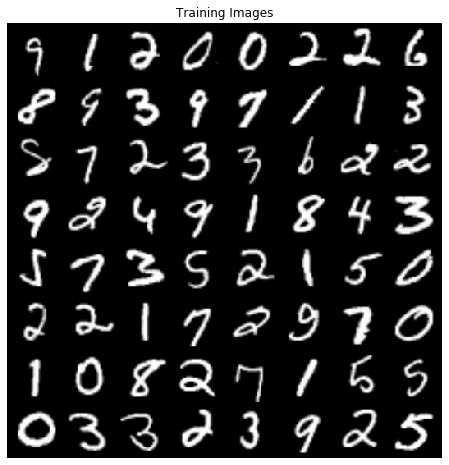

In [5]:
dataiter = iter(trainloader)
real_batch = dataiter.next()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.show()

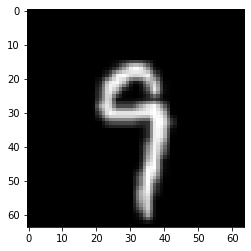

In [6]:
plt.imshow(real_batch[0][0,:,:].reshape(64, 64), cmap='gray')
plt.show()

## Weight Initialization
As per the paper the model and weights were initialized form a normal distribution of 0.0 - 0.2 

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.2)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


## HyperParameter Initialization

In [0]:
dataroot = "data/MNIST"

image_size = 64

latent_vectors = 100

feature_maps = 128

output = 1
# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 2e-4

# Beta1 hyperparam for Adam optimizers
beta1 = (0.5, 0.999)

## Generator

In [0]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Z starts convolutional transpose
            nn.ConvTranspose2d(in_channels=latent_vectors, out_channels=feature_maps * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),
            # state size. (feature_maps*8) x 4 x 4
            nn.ConvTranspose2d(in_channels=feature_maps*8, out_channels=feature_maps*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps*4),
            nn.ReLU(True),
            # state size. (feature_maps*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=feature_maps*4, out_channels=feature_maps*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps*2),
            nn.ReLU(True),
            # State Size feature_maps*2 x 16 x 16
            nn.ConvTranspose2d(in_channels=feature_maps*2, out_channels=feature_maps, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            # State Size feature_maps x 32 x 32
            nn.ConvTranspose2d(in_channels=feature_maps, out_channels=output, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # State size nc x 64 x 64
        )

    def forward(self, x):
        return self.main(x)

In [10]:
generator = Generator().to(device)
# generator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (output) x 64 x 64
            nn.Conv2d(output, feature_maps, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (feature_maps) x 32 x 32
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (feature_maps*2) x 16 x 16
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (feature_maps*4) x 8 x 8
            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [12]:
discriminator = Discriminator().to(device)
# discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12656257 and discriminator: 11033984


# Training

In [14]:
criterion = nn.BCELoss()

real_label = 1
fake_label = 0

optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=beta1)
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=beta1)

generator.train()
discriminator.train()



# Discriminator(
#   (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
#   (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
#   (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
#   (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
#   (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
# )

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [15]:
generator
# Generator(
#   (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
#   (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
#   (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
#   (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
#   (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
# )

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [16]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    G_losses.append(0)
    D_losses.append(0)
    num_batches = 0
    
    for i, (image_batch, _) in tqdm(enumerate(trainloader, 0)):

        optimizerD.zero_grad()

        # Creating Real and Fake Labels
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # Generate Images from Latents
        latent = torch.randn(image_batch.size(0), latent_vectors, 1, 1, device=device)
        fake_images = generator(latent)


        # Training Discriminator to tell what is real and what is fake
        # Also we detach the fake images so that changes are not backpropagated
        # to the generator
        real_predictions = discriminator(image_batch).squeeze()
        fake_predictions = discriminator(fake_images.detach()).squeeze()
        discriminator_loss = 0.5 * ( 
                    criterion(real_predictions, label_real) +
                    criterion(fake_predictions, label_fake)  
                    )

        discriminator_loss.backward()
        optimizerD.step()



        # Train the generator to make images that are classified as real
        # This time we want to backpropagate therefore no detach()
        optimizerG.zero_grad()
        fake_predictions = discriminator(fake_images).squeeze()
        generator_loss = criterion(fake_predictions, label_real)

        generator_loss.backward()
        optimizerG.step()


        G_losses[-1] += generator_loss.item()
        D_losses[-1] += discriminator_loss.item()

        

        if num_batches % 50 == 0:
            print('[{}/{}][{}/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}'.format
                  (epoch, num_epochs, num_batches, len(trainloader),
                     discriminator_loss.item(), generator_loss.item()))
            
        num_batches += 1

    G_losses[-1] /= num_batches
    D_losses[-1] /= num_batches
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, G_losses[-1], D_losses[-1]))

Starting Training Loop...


[0/5][0/469]	Loss_D: 0.6903	Loss_G: 3.4000
[0/5][50/469]	Loss_D: 0.0008	Loss_G: 7.9026
[0/5][100/469]	Loss_D: 0.0007	Loss_G: 8.0917
[0/5][150/469]	Loss_D: 0.0010	Loss_G: 8.3341
[0/5][200/469]	Loss_D: 0.0045	Loss_G: 6.0373
[0/5][250/469]	Loss_D: 0.0149	Loss_G: 7.2951
[0/5][300/469]	Loss_D: 0.0002	Loss_G: 20.5914
[0/5][350/469]	Loss_D: 0.0077	Loss_G: 9.4075
[0/5][400/469]	Loss_D: 0.0947	Loss_G: 3.7904
[0/5][450/469]	Loss_D: 0.0036	Loss_G: 6.2608

Epoch [1 / 5] average loss generator vs. discrim.: 9.458843 vs. 0.136132


[1/5][0/469]	Loss_D: 1.3743	Loss_G: 6.3351
[1/5][50/469]	Loss_D: 0.2019	Loss_G: 2.5092
[1/5][100/469]	Loss_D: 0.1474	Loss_G: 2.8013
[1/5][150/469]	Loss_D: 1.2973	Loss_G: 0.6294
[1/5][200/469]	Loss_D: 0.3189	Loss_G: 1.6712
[1/5][250/469]	Loss_D: 0.3877	Loss_G: 1.4254
[1/5][300/469]	Loss_D: 0.4575	Loss_G: 2.8356
[1/5][350/469]	Loss_D: 0.5499	Loss_G: 0.5623
[1/5][400/469]	Loss_D: 0.5350	Loss_G: 1.2339
[1/5][450/469]	Loss_D: 0.4389	Loss_G: 1.6295

Epoch [2 / 5] average loss generator vs. discrim.: 2.385136 vs. 0.483147


[2/5][0/469]	Loss_D: 0.3335	Loss_G: 1.4885
[2/5][50/469]	Loss_D: 0.3159	Loss_G: 1.6759
[2/5][100/469]	Loss_D: 0.7536	Loss_G: 2.5992
[2/5][150/469]	Loss_D: 0.6052	Loss_G: 0.9450
[2/5][200/469]	Loss_D: 0.3363	Loss_G: 1.5804
[2/5][250/469]	Loss_D: 0.1256	Loss_G: 3.3108
[2/5][300/469]	Loss_D: 0.0142	Loss_G: 4.8423
[2/5][350/469]	Loss_D: 0.0021	Loss_G: 8.2806
[2/5][400/469]	Loss_D: 0.0034	Loss_G: 6.2285
[2/5][450/469]	Loss_D: 0.0013	Loss_G: 7.0172

Epoch [3 / 5] average loss generator vs. discrim.: 3.770454 vs. 0.290217


[3/5][0/469]	Loss_D: 0.0021	Loss_G: 6.5160
[3/5][50/469]	Loss_D: 0.1359	Loss_G: 4.5229
[3/5][100/469]	Loss_D: 0.2192	Loss_G: 0.1547
[3/5][150/469]	Loss_D: 0.2980	Loss_G: 1.9655
[3/5][200/469]	Loss_D: 0.4025	Loss_G: 1.0281
[3/5][250/469]	Loss_D: 0.2036	Loss_G: 2.4198
[3/5][300/469]	Loss_D: 0.1457	Loss_G: 3.6069
[3/5][350/469]	Loss_D: 0.1975	Loss_G: 2.3177
[3/5][400/469]	Loss_D: 0.0533	Loss_G: 5.2814
[3/5][450/469]	Loss_D: 0.1657	Loss_G: 3.2643

Epoch [4 / 5] average loss generator vs. discrim.: 3.184216 vs. 0.359507


[4/5][0/469]	Loss_D: 0.3292	Loss_G: 3.3712
[4/5][50/469]	Loss_D: 0.0139	Loss_G: 7.8050
[4/5][100/469]	Loss_D: 0.3812	Loss_G: 3.1636
[4/5][150/469]	Loss_D: 0.4628	Loss_G: 2.2438
[4/5][200/469]	Loss_D: 0.6093	Loss_G: 1.4092
[4/5][250/469]	Loss_D: 0.0383	Loss_G: 5.2200
[4/5][300/469]	Loss_D: 0.0066	Loss_G: 5.9539
[4/5][350/469]	Loss_D: 0.2907	Loss_G: 5.4543
[4/5][400/469]	Loss_D: 0.2072	Loss_G: 2.6359
[4/5][450/469]	Loss_D: 0.4367	Loss_G: 2.8146

Epoch [5 / 5] average loss generator vs. discrim.: 3.612999 vs. 0.303527


# Generating Images with the Generator

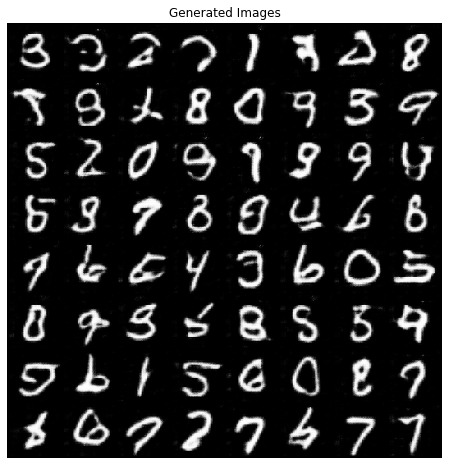

In [27]:
generator.eval()

with torch.no_grad():

    latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
    fake_image_batch = generator(latent)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(fake_image_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

    plt.show()